In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="CHANGE-TO-YOUR-API-KEY")
project = rf.workspace("utm-zaimq").project("skin-diseases-bkejc")
version = project.version(3)
dataset = version.download("folder")
                

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.2 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to skin-diseases-3 in folder:: 100%|██████████| 5202/5202 [00:00<00:00, 6129.75it/s]


In [3]:
import torch
from torch import nn, optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
def plot_training_history(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Val Loss', marker='o')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [5]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define transformations for train and validation data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((640, 640)),  # Resize images to 640x640
        transforms.RandomHorizontalFlip(),  # Random horizontal flip for augmentation
        transforms.RandomRotation(15),  # Random rotation for augmentation
        transforms.ColorJitter(contrast=0.2),  # Color jitter
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize (ImageNet stats)
    ]),
    'val': transforms.Compose([
        transforms.Resize((640, 640)),  # Resize images to 640x640
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize (ImageNet stats)
    ]),
}

data_dir = "/kaggle/working/skin-diseases-3"
# Load datasets
train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=f'{data_dir}/valid', transform=data_transforms['val'])

# Data loaders
batch_size = 16  # Adjust batch size based on your GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


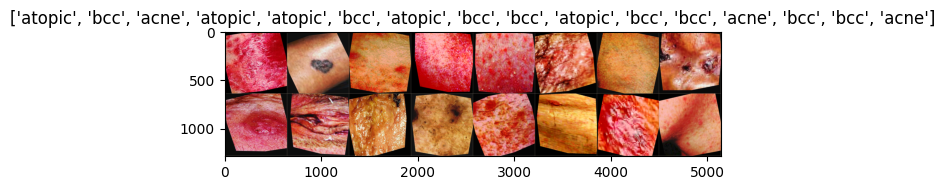

In [6]:
# Visualize a batch of training data
import matplotlib.pyplot as plt
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[train_dataset.classes[c] for c in classes])

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Modify the input layer for larger image size (640x640 is implicitly supported by convolutional layers).
# Add Dropout and Layer Normalization
class EnhancedResNet50(nn.Module):
    def __init__(self, original_model, num_classes=10):
        super(EnhancedResNet50, self).__init__()
        self.resnet_features = nn.Sequential(
            original_model.conv1,
            original_model.bn1,
            nn.Dropout(p=0.2),  # Add dropout after first layer
            original_model.relu,
            original_model.maxpool,
            original_model.layer1,
            original_model.layer2,
            nn.Dropout(p=0.2),  # Add dropout after layer 2
            original_model.layer3,
            original_model.layer4
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Maintain global average pooling
        self.classifier = nn.Sequential(
            nn.LayerNorm(2048),  # Normalize the features
            nn.Dropout(p=0.2),  # Dropout before classification
            nn.Linear(2048, num_classes)  # Final fully connected layer
        )

    def forward(self, x):
        x = self.resnet_features(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Number of classes in your dataset
num_classes = 3  
model = EnhancedResNet50(model, num_classes=num_classes)
model = model.to(device)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

In [10]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize history lists
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Training function remains the same
def train_model(model, train_loader, val_loader, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()  # Set model to training mode

        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track training loss and accuracy
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds
        train_loss_history.append(train_loss)
        train_acc_history.append(train_accuracy)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0

        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct_preds += (preds == labels).sum().item()
                val_total_preds += labels.size(0)

        val_loss = val_running_loss / len(val_loader)
        val_accuracy = val_correct_preds / val_total_preds
        val_loss_history.append(val_loss)
        val_acc_history.append(val_accuracy)
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Step the learning rate scheduler
        scheduler.step()

    return model



In [11]:
num_epochs = 15
trained_model = train_model(model, train_loader, val_loader, num_epochs=num_epochs)

Epoch 1/15
Train Loss: 0.6578, Train Accuracy: 0.7314
Val Loss: 1.0408, Val Accuracy: 0.6238
Epoch 2/15
Train Loss: 0.4395, Train Accuracy: 0.8207
Val Loss: 0.7645, Val Accuracy: 0.6762
Epoch 3/15
Train Loss: 0.3973, Train Accuracy: 0.8410
Val Loss: 0.8650, Val Accuracy: 0.7143
Epoch 4/15
Train Loss: 0.3249, Train Accuracy: 0.8678
Val Loss: 0.8979, Val Accuracy: 0.7143
Epoch 5/15
Train Loss: 0.2784, Train Accuracy: 0.8877
Val Loss: 0.5815, Val Accuracy: 0.7571
Epoch 6/15
Train Loss: 0.1675, Train Accuracy: 0.9376
Val Loss: 0.4534, Val Accuracy: 0.8143
Epoch 7/15
Train Loss: 0.1234, Train Accuracy: 0.9554
Val Loss: 0.4664, Val Accuracy: 0.8000
Epoch 8/15
Train Loss: 0.0975, Train Accuracy: 0.9663
Val Loss: 0.5039, Val Accuracy: 0.8190
Epoch 9/15
Train Loss: 0.0902, Train Accuracy: 0.9688
Val Loss: 0.5838, Val Accuracy: 0.8095
Epoch 10/15
Train Loss: 0.0893, Train Accuracy: 0.9661
Val Loss: 0.5783, Val Accuracy: 0.7952
Epoch 11/15


KeyboardInterrupt: 

In [12]:
train_acc_history

[0.7314058244290802,
 0.8206578671694951,
 0.84098051539912,
 0.8677980305887283,
 0.8877016551435156,
 0.9375654724491934,
 0.9553739786297926,
 0.9662685941755709,
 0.9687827362245967,
 0.9660590823381521]

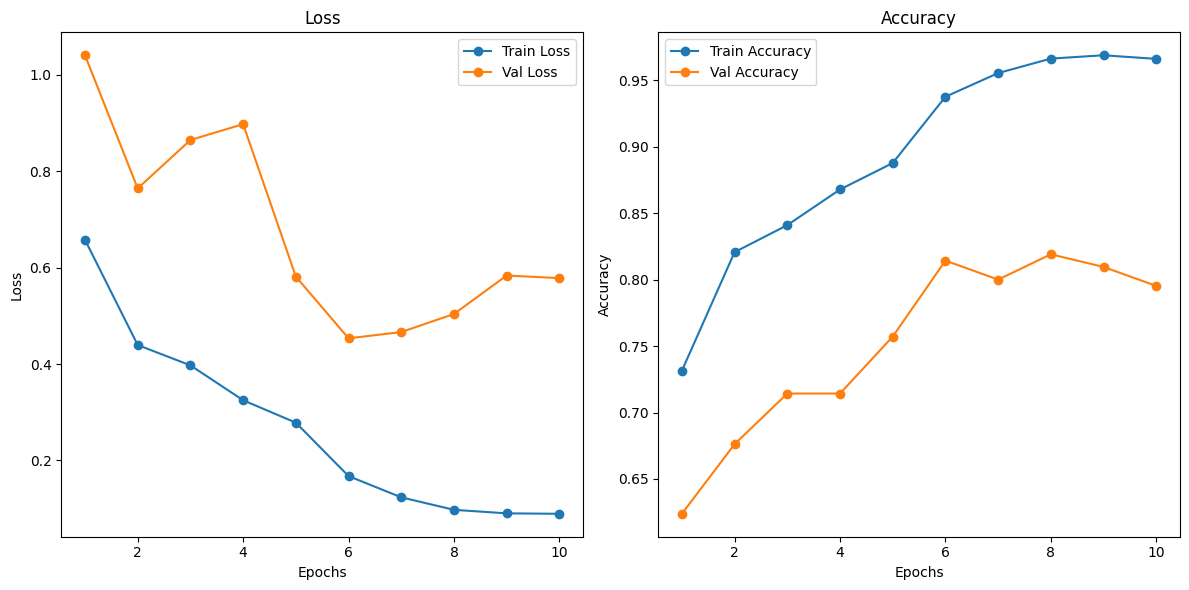

In [13]:
def plot_training_history(train_loss, val_loss, train_acc, val_acc):
    epochs = range(1, len(train_loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Val Loss', marker='o')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Val Accuracy', marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch

In [20]:
def evaluate_model(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get class predictions
            
            # Collect predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate on validation set
print("Validation Metrics:")
evaluate_model(model, val_loader, device)

Validation Metrics:
Accuracy: 0.7905
F1-Score: 0.7888
Precision: 0.8130
Recall: 0.7905
